# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Standard Section 6: Feed Forward Neural Networks

**Harvard University**<br/>
**Fall 2018**<br/>
**Section Leaders:** Mehul Smriti Raje, Ken Arnold, Karan Motwani, Cecilia Garraffo<br/>
**Instructors:** Pavlos Protopapas, Kevin Rader <br/>
**Author:** Mehul Smriti Raje

In this section we will discover how to create feed-forward neural networks using a fun dataset. The goal is to familiarize you with manual implementations of Neural Networks. The exercises below will help you be able to answer parts of Homework 6.

Specifically, we will: 
    
    1. Import data, explore with analyse relationship with response.
    2. Fit some previously used regression models, understand drawbacks and interpret results.
    3. Construct a feed-forward NN for regression, compare performance and interpret results.


For this section we will be using the following packages:

In [1]:
# Data and Stats packages
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, r2_score

# Visualization packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (13.0, 6.0)

# Aesthetic settings
from IPython.display import display
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 500)
sns.set_style('whitegrid')
sns.set_context('talk')

# Fun Dataset

Let us import a fun dataset specially created to show you how to play with neural networks.

In [2]:
#Import dataframe
fun_df = pd.read_csv('data/fun_dataset.csv')
fun_df = fun_df[['x', 'y']]
display(fun_df.head())
print(fun_df.shape)

,x,y
0,2.617188,-2.265495
1,0.000000,0.000000
2,9.375000,-9.363387
3,8.320312,-3.740912
4,0.195312,0.191599


(100, 2)


Let us peek and see how the data is distributed.

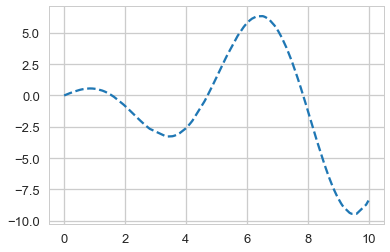

In [3]:
fun_df = fun_df.sort_values(by = 'x')
plt.plot(fun_df.x, fun_df.y, '--')

We see that there are two distinct humps in the data. We will try to qualitatively check if our models generalise well on these.

# Can we model this data using Logistic Regression/Polynomial Regression

In [4]:
# Defining X and Y
X = fun_df.x
Y = fun_df.y

In [5]:
fun_df.describe()

,x,y
count,100.000000,100.000000
mean,4.828125,-0.707590
std,3.016739,4.377725
min,0.000000,-9.449327
25%,2.333984,-2.751728
50%,4.941406,0.019516
75%,7.470703,1.532279
max,10.000000,6.336071


### Doing the same old pre-processing

In [6]:
# Splitting into train and test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=9001)

# Re-shaping data
x_train, y_train = x_train.values.reshape(-1,1), y_train.values
x_test, y_test = x_test.values.reshape(-1,1), y_test.values
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(75, 1) (25, 1) (75,) (25,)


**Question 1:** Should we normalise/standardise the data here? Why or why not?

In [7]:
# standardising values
means = {'x': x_train.mean(), 'y': y_train.mean()}
stds = {'x': x_train.std(), 'y': y_train.std()}

x_train = (x_train - means['x'])/stds['x']
y_train = (y_train - means['y'])/stds['y']

x_test = (x_test - means['x'])/stds['x']
y_test = (y_test - means['y'])/stds['y']

>**Answer:** Standardising the data helps in faster convergence of optimisation algorithms, especially when building neural networks. Thus, we standardise our data.

**Question 2:** Would you use Logistic Regression for this data? Why/why not? 

> **Answer:** The response variable for this dataset is not binary. hence, I would refrain from using Logistic Regression

### Fitting Polynomial Regression

**Question 3:** Would you use polynomial regression for this data? Why/why not? If yes, what degree of polynomial would you pick? Why?

>**Answer:** Looking at the data, it seems that there is a at least a quadratic relation between the predictor and response variables. Thus, I would want to experiment with polynomial regression.

>I can see about 4 trends in the data distribution. So, I'd like to start experimenting with polynomials around degree 4.

Let us try fitting with different degrees of polynomials between 2-15.

In [8]:
# Fitting model with degree deg
result_df = pd.DataFrame({'x_train': x_train[:,0], 
                          'y_train': y_train, 
                         })
models_df = {}

degrees = [3,5,10,15]

for deg in degrees:

    # Preparing data
    poly = PolynomialFeatures(degree=deg, )
    x_train_poly = poly.fit_transform(x_train)
    x_test_poly = poly.fit_transform(x_test)

    # Training
    linreg = LinearRegression()
    linreg.fit(x_train_poly, y_train)

    # Predict and convert to binary responses
    y_pred_train = linreg.predict(x_train_poly)
    y_pred_test = linreg.predict(x_test_poly)

    # Performance Evaluation
    train_score = r2_score(y_train, y_pred_train)*100
    test_score = r2_score(y_test, y_pred_test)*100
    
    # store in df
    result_df['y_train_pred_{}'.format(deg)] = y_pred_train
    models_df[deg] = [linreg, x_train_poly.shape, train_score, test_score]

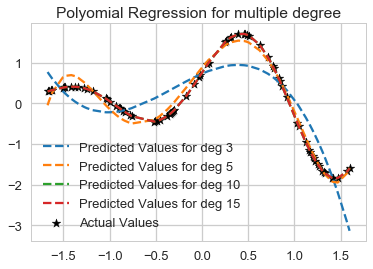

In [9]:
# Plotting results 
result_df = result_df.sort_values(by = 'x_train')
plt.scatter(result_df.x_train, result_df.y_train, color='k', marker='*', label='Actual Values')

for deg in degrees:
    plt.plot(result_df.x_train, result_df['y_train_pred_{}'.format(deg)], '--', 
             label='Predicted Values for deg {}'.format(deg))
    
plt.title('Polyomial Regression for multiple degree')
plt.legend()

We see that both poynomials of degree 15 does a great job of capturing the data well. We choose the model with degree 15.

In [10]:
degree_chosen = 15
print("Number of features:",models_df[degree_chosen][1])
print("Training Set Accuracy:",str(models_df[degree_chosen][2])+'%')
print("Testing Set Accuracy:",str(models_df[degree_chosen][3])+'%')

Number of features: (75, 16)
Training Set Accuracy: 99.99999999999255%
Testing Set Accuracy: 99.99999999996537%


We observe that we require 16 features and a polynomial of degree 15 to model the data with nearly perfect accuracy.

# Let's now try to model this data using a Feed-Forward Neural Network

**Question 4:** What is the shape of input and output arrays to the neural network?

In [11]:
print(x_train.shape, y_train.shape)

(75, 1) (75,)


Let us construct a network with a single hidden layer. We will now define the parameters of our network. Let us choose the number of hidden layers to be 3.

In [12]:
input_dim = 1
output_dim = 1

num_hidden_layers = 1
num_hidden_nodes = 3

**Question 5:** What are the shapes of the weight matrices for the network?

In [13]:
print("WL0: ({0},{1})".format(num_hidden_nodes, input_dim+1))
print("WL1: ({0},{1})".format(output_dim, num_hidden_nodes+1))

WL0: (3,2)
WL1: (1,4)


### Choosing an activation function

**Question 6:** How do we pick an activation function for our neural network?

>**Answer 6:** Activation functions are chosen based on the nature of the problem. We will cover more about this in lectures.

We will work with the sigmoid activation function here.

In [14]:
sigmoid = lambda x: (1/(1 + np.exp(-x)))

Let's now create a feed-forward network with this activation function.

### Let us assign all 1s to initialise both WL0 and WL1

In [15]:
# ASSIGNING WEIGHTS

# all 1s
WL0 = np.ones((num_hidden_nodes, input_dim+1))
WL1 = np.ones((output_dim, num_hidden_nodes+1))                

print(WL0);
print(WL1)

[[1. 1.]
 [1. 1.]
 [1. 1.]]
[[1. 1. 1. 1.]]


In [15]:
# FORWARD PROPAGATION

# input layer
ones = np.ones((len(x_train),1))    
L0 = x_train 
L0 = np.append(L0, ones, axis=1)

# hidden layer
a0 = np.dot(WL0, L0.T)
z0 = {'sigmoid': sigmoid(a0)}

# output layer 
ones = np.ones((len(y_train),1))
z0['sigmoid'] = np.append(z0['sigmoid'].T, ones,axis=1).T

# affine 
a1 = {'sigmoid': np.dot(WL1, z0['sigmoid'])}
z1 = a1

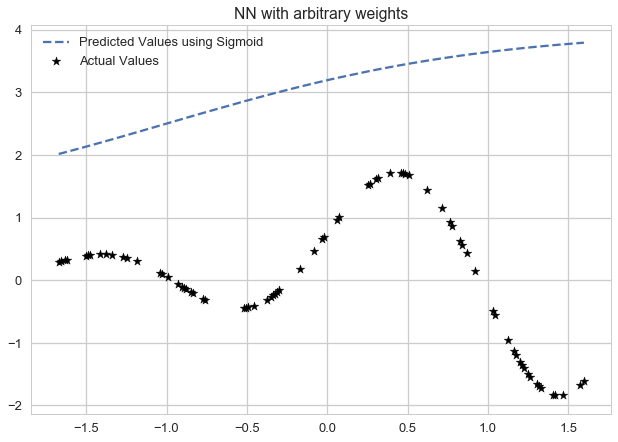

In [16]:
# PLOTTING THE MODEL
def plot_nn_models(result_df, title, sig):
    result_df = result_df.sort_values(by = 'x_train')
    plt.scatter(result_df.x_train, result_df.y_train, color='k', marker='*', label='Actual Values')
    if sig:
        plt.plot(result_df.x_train, result_df.y_pred_train_sigmoid, '--', label='Predicted Values using Sigmoid')
    plt.title(title)
    plt.legend()
    return

result_df = pd.DataFrame({'x_train': x_train[:,0], 
                          'y_train': y_train, 
                          'y_pred_train_sigmoid': z1['sigmoid'][0]
                         })
plot_nn_models(result_df, 'NN with arbitrary weights', True)

**Question 7:** Does the current NN capture the trends in data? If no, how should we modify our network?

> **Answer:** The network is not doing a good job at approximating the function well right now. We need to experiment and find out whether we need to change the weights, number of hidden nodes or number of hidden layers.

### Let us first adjust weights to try and find a model that matches our data well

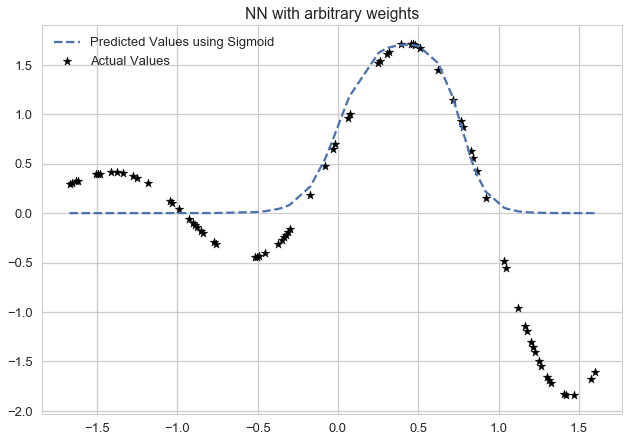

In [17]:
# ASSIGNING WEIGHTS

# Obtained using trial and error
WL0 = {'sigmoid': np.array([[10,0.01], [13,-10], [0.1,20]])}
WL1 = {'sigmoid': np.array([[1.75, -1.75, 1, -1]])}


# FORWARD PROPAGATION

# input layer
ones = np.ones((len(x_train),1))    
L0 = x_train 
L0 = np.append(L0, ones, axis=1)

# hidden layer
a0 = {'sigmoid': np.dot(WL0['sigmoid'], L0.T)}
z0 = {'sigmoid': sigmoid(a0['sigmoid'])}

# output layer 
ones = np.ones((len(y_train),1))
z0['sigmoid'] = np.append(z0['sigmoid'].T, ones,axis=1).T

# affine 
a1 = {'sigmoid': np.dot(WL1['sigmoid'], z0['sigmoid'])}
z1 = a1


# PLOTTING THE MODEL
result_df = pd.DataFrame({'x_train': x_train[:,0], 
                          'y_train': y_train, 
                          'y_pred_train_sigmoid': z1['sigmoid'][0]
                         })
plot_nn_models(result_df, 'NN with arbitrary weights', True)

With some adjusted weights (obtained by trial and error and logically observing which weight changes which part of approximation), we see that the sigmoid activation functions is doing a really good job at capturing the hump between `x=-0.2` to `x=1`. 

The weights obtained by our most suitable model having 3 hidden nodes are given below:

In [18]:
print("WL0: \n", WL0['sigmoid'], "\n")
print("WL1: \n", WL1['sigmoid'])

WL0: 
 [[  1.00000000e+01   1.00000000e-02]
 [  1.30000000e+01  -1.00000000e+01]
 [  1.00000000e-01   2.00000000e+01]] 

WL1: 
 [[ 1.75 -1.75  1.   -1.  ]]


### Let us now increase the number of hidden nodes to 4 and use Sigmoid as our activation function to see if we can find a model that matches our data better

In [19]:
# Re-defining the number of hidden nodes
num_hidden_nodes = 4

# Printing shape of weight vectors
print("WL0: ({0},{1})".format(num_hidden_nodes, input_dim+1))
print("WL1: ({0},{1})".format(output_dim, num_hidden_nodes+1))

WL0: (4,2)
WL1: (1,5)


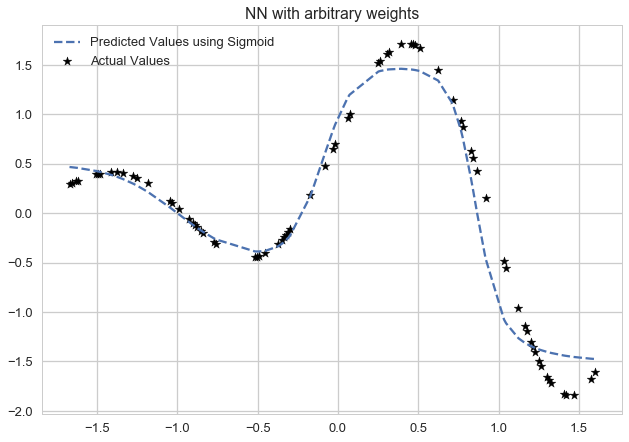

In [20]:
# ASSIGNING WEIGHTS

# Obtained using trial and error
WL0 = {'sigmoid': np.array([[10,1], [-5,-5], [14,-12], [-5,5]])}
WL1 = {'sigmoid': np.array([[2, 1, -2.5, 0.5, -1]])}


# FORWARD PROPAGATION

# input layer
ones = np.ones((len(x_train),1))    
L0 = x_train 
L0 = np.append(L0, ones, axis=1)

# hidden layer
a0 = {'sigmoid': np.dot(WL0['sigmoid'], L0.T)}
z0 = {'sigmoid': sigmoid(a0['sigmoid'])}

# output layer 
ones = np.ones((len(y_train),1))
z0['sigmoid'] = np.append(z0['sigmoid'].T, ones,axis=1).T

# affine 
a1 = {'sigmoid': np.dot(WL1['sigmoid'], z0['sigmoid'])}
z1 = a1


# PLOTTING THE MODEL
result_df = pd.DataFrame({'x_train': x_train[:,0], 
                          'y_train': y_train, 
                          'y_pred_train_sigmoid': z1['sigmoid'][0]
                         })
plot_nn_models(result_df, 'NN with arbitrary weights', True)

After several trial and errors, we have found that adding an additional node helps the model generalise well on the second hump between `x=-1.5` and `x=0` also, adding to it's generalisation on the other hump as seen before. 

The weights obtained by our most suitable model having 4 hidden nodes are given below:

In [21]:
WL0_best, WL1_best = WL0['sigmoid'], WL1['sigmoid']

print("WL0: \n", WL0_best, "\n")
print("WL1: \n", WL1_best)

WL0: 
 [[ 10   1]
 [ -5  -5]
 [ 14 -12]
 [ -5   5]] 

WL1: 
 [[ 2.   1.  -2.5  0.5 -1. ]]


**Similarly, can we improve our function fit by increasing the number of hidden nodes?**

# Performance of NN

**Question 8:** So far, we are qualitatively determining if our feed-forward neural network models our data well. Can we quantitaively determine this? How?

>**Answer: ** Yes! We can quantitatively determine the performance of our model by choose the metric we want to use. Let's use the MSE values to determine the loss from our model (as we have done in cases of regression before). The loss, as we know, indicated how well our model fits the data. Look up other loss functions used by neual networks here: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html

> What metric would you use if the data had categorical target variables?

Let us calculate the loss from our network.

In [22]:
loss = sum((result_df.y_pred_train_sigmoid - result_df.y_train)**2)
print(loss)

3.10369819692


**Question 9:** Lets transport back in time to our favourite calculus lessons. How do we minimise the loss of any function approximation?

>**Answer** One way to do this is by adjusting the function approximation parameters using a technique called gradient descent. 

> We have also covred gradient descent in the previous lecture. Look at the slides for Lecture 12 for reference.

Let us explore gradient descent below.

### Gradient Descent

**Theory**

At any point in one dimension, a function's derivative tells us whether increasing the input will increase the function (positive derivative) or decrease the function (negative derivative). The derivative also tells us how much we think the function will increase/decrease for a small change in the input. We're being told which direction we want to move in, and how strongly we want to make that move.

With multiple inputs, we can take a derivative with respect to any of the inputs, but the result still holds. Let's say the derivative with respect to `input1` is `+k1` and the derivative with respect to `input2` is `-k2`? We still want to increase `input1` and decrease `input2`... but by how much? It turns out that a ratio of `k1:k2` (exactly what the derivatives told us) is optimal, at least near our current point. So we say `new_point = old_point + .01 * (k1,-k2)`. Thus, we increase the first input by `.01 * k1` and decrease the second input by `.01 * k2`, and then ask about the derivatives at the new point to make further update.

**Example showing use of gradient descent to find function minima using approximation**

Let us define a function `f(x) = sin(x) + cos(x)` and guess that it has a minimum value of `f(x) = -1` at parameter value `x_min = 1`. Let us now use gradient descent to optimize the approximation of `x_min`.

In [23]:
# inline function for f(x)
f = lambda x: np.sin(x) + np.cos(x)

We calculate the gradient of `f(x)` wrt `x` to be `f'(x) = cos(x) - sin(x)`.

In [24]:
# inline function for df/dx
der_f_x = lambda x: np.cos(x) - np.sin(x)

We calculate the gradient at `x_min` and update its approximation for 1000 iterations to see how the values change.

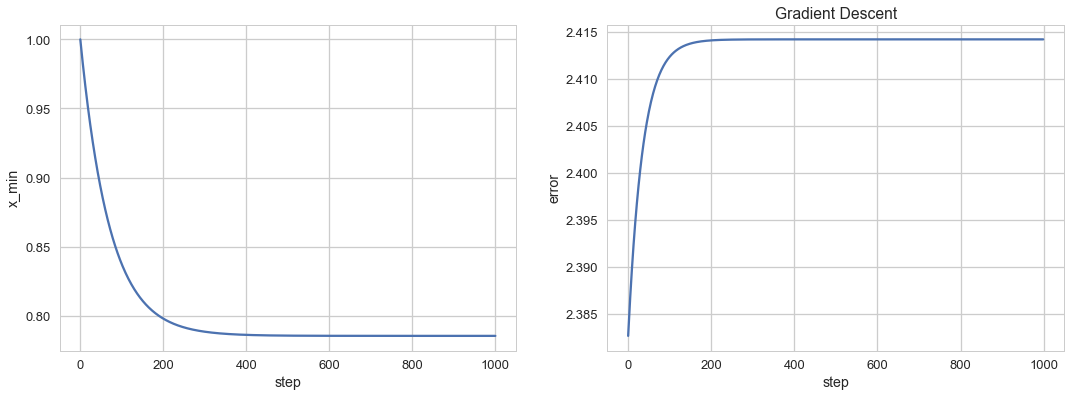

In [25]:
x_n_minus_1 = 1
f_x_min = -1
x_vals = [x_n_minus_1]
errors = []

l = 0.01 # learning rate

for i in range(1000):
    gradient_eval = der_f_x(x_n_minus_1) # evaluating gradient at x_(n-1), i.e. previous parameter approximation
    x_n = x_n_minus_1 + l*gradient_eval # updating approximation of x_min
    f_eval = f(x_n) # evaluating function at new point
    error = f_eval - f_x_min # finding error in approximation
    
    errors.append(error) # storing values of error
    x_vals.append(x_n) # storing values of x_min
    
    x_n_minus_1 = x_n # x_n is the previous step now
    
    
figure, ax = plt.subplots(1, 2, figsize=(18,6))
ax[0].plot(range(1001), x_vals)
ax[0].set_xlabel('step')
ax[0].set_ylabel('x_min')
ax[1].set_title('Gradient Descent')

ax[1].plot(range(1000), errors)
ax[1].set_xlabel('step')
ax[1].set_ylabel('error')
ax[1].set_title('Gradient Descent')

We can observe that the error and `x_min` approximation values stop changing after around 300 approximations, i.e. the approximated value of `x_min` has become nearly static. Let us see what these approximated values are.

In [26]:
print('x_min = ', x_vals[-1])
print('error = ', error)

x_min =  0.785398303888
error =  2.41421356237


**Question 10:** How do we determine the number of steps taken to reach our optimal weight values?

>**Answer:** Another way to perform gradient descent is to define a threshold and stop iterating when the values change becomes smaller than this threshold value. Let us do this to find the number of steps taken to reach the optimal value.

In [27]:
x_n_minus_1 = 1
f_x_min = -1
x_vals = [x_n_minus_1]
errors = []

l = 0.01 # learning rate
error = 1
step = 0
threshold = 0.0001

while True:
    gradient_eval = der_f_x(x_n_minus_1) # evaluating gradient at x_(n-1), i.e. previous parameter approximation
    x_n = x_n_minus_1 + l*gradient_eval # updating approximation of x_min
    f_eval = f(x_n) # evaluating function at new point
    error = f_eval - f_x_min # finding error in approximation
    
    errors.append(error) # storing values of error
    x_vals.append(x_n) # storing values of x_min
    
    x_n_minus_1 = x_n # x_n is the previous step now
    step += 1
    
    if abs(f_eval - f(x_vals[step-1])) < threshold: break
    
print('Number of steps = ', step)

Number of steps =  79


Thus, we see that with a learning rate of 0.01, it took us 79 steps to reach optimal values of our parameter.

**Question 11:** How was this learning rate chosen?

>**Answer** Here, the choice of the 'learning rate' (lr) as .01 was arbitrary: bigger values of learning rates let us move more quickly towards the optimal value, but will be less accurate. Small learning rates are safe, but slow, while rates that are too big will fail to converge. Finding the right value is tricky and often times in complex problems, people experiment with many values of lr.

Gradient descent can performed on weights of neural networks to determine their optimal values that can yield the highest network accuracies.

### Testing on Unseen Data

Let us now check the performance of our NN on unseen test data, using our observations and optimal weight values from above.

In [28]:
# WL0_best and WL1_best are the best weight values we have obtained
# We have trained the network using x_train above
# We now apply the same transformatons on x_test

# input layer
ones = np.ones((len(x_test),1))    
L0 = x_test 
L0 = np.append(L0, ones, axis=1)

# hidden layer
a0 = np.dot(WL0_best, L0.T)
z0 = sigmoid(a0)

# output layer 
ones = np.ones((len(y_test),1))
z0 = np.append(z0.T, ones,axis=1).T

# affine with sigmoid
a1 = np.dot(WL1_best, z0)
z1 = a1 
y_pred_test = z1  # THIS IS THE OUTPUT FOR TEST DATA

In [29]:
# Performance Evaluation
train_score = r2_score(y_train, result_df.y_pred_train_sigmoid)*100 # THIS WAS FOUND ABOVE ALREADY
test_score = r2_score(y_test, y_pred_test[0])*100

print("Training Set Accuracy:",str(train_score)+'%')
print("Testing Set Accuracy:",str(test_score)+'%')

Training Set Accuracy: 95.8617357374%
Testing Set Accuracy: 96.3285378691%


**We can observe that our manually constructed feed-forward neural network gave us comparable results to the polynomial model constructed before. Here, we adjusted 13 parameters with a single input feature, compared to 16 parameters and 15 features in the polynomial model.**